# Catchment hydrological model with 5 parameters
In this Notebook we are going to use a hydrological model, run it and calibrate it to try to understand how it works.

Imagine that we want to predict the hydrograph of a river that collects water from a basin when it rains. For this purpose we use a hydrological model, which is nothing more than a set of equations that describe in a simplified way the hydrological processes that occur in the basin. These equations include different parameters that describe some of the properties of the basin, for example the characteristics of the soil.
![diagrama cuenca](images/diagrama_cuenca.gif)

In this example, we are going to use a simple model (an adaptation of the model [HyMOD](https://doi.org/10.1029/WS006)) which has 5 parameters:

- **Soil storage capacity** (mm): capacity of the soil to retain rainwater
- **Evaporation ratio**: evaporation ratio or proportion of rain that evaporates
- **Percolation ratio**: proportion of effective rainwater (that does not evaporate) that percolates into the ground.
- **Travel time - surface flow** (days): surface water concentration time or time it takes for surface water to reach the mouth of the basin.
- **Travel time - underground flow** (days): groundwater concentration time or time it takes for groundwater to reach the mouth of the basin.

In the image below we can see how the model represents the hydrological processes in order to finally obtain the prediction of the river's hydrograph for the coming months. As you can see, the soil is presented as a deposit with a certain capacity that, if exceeded, overflows, generating surface flow and that also displaces water through its lower part, generating groundwater.

![diagrama modelo hidrologico](images/Diagrama_modelo.gif)

The first thing, as always, is to import the function libraries that we are going to need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from util.interactive_plots import interactive_plot_1

## Load data
We have **observed daily rainfall (mm/day), daily evapotranspiration (etp; mm/day) and outflow or runoff (m3/day) data from 2010 to 2019** in a Excel file that we are going to load and save as a variable called `obs_data`

In [2]:
obs_data = pd.read_excel('data/data example 2.xlsx',index_col = 'date')
obs_data # to print the data on screen

,rain,etp,outflow
date,,,
2010-01-01,2.032,1.168133,6531.84
2010-01-02,25.654,0.262242,6531.84
2010-01-03,13.462,0.991814,74995.20
2010-01-04,24.638,0.808446,33868.80
2010-01-05,0.000,0.849716,101606.40
...,...,...,...
2019-12-28,0.000,0.200841,9918.72
2019-12-29,0.000,0.738878,8951.04
2019-12-30,0.000,0.848909,8467.20


Let's **plot the observed rainfall rate** of one specific year, for example **2010**

Text(0.5, 1.0, 'Hyetograph (daily rainfall)')

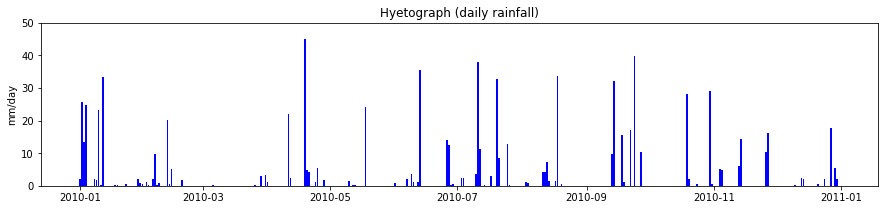

In [3]:
year_of_study = 2010
obs_data_year = obs_data[obs_data.index.year == year_of_study] # to select only data from to the year that we want to study
plt.figure(figsize=(15,3)) # to define the plot size
plt.bar(obs_data_year.index, obs_data_year['rain'], color = 'blue')
plt.ylabel('mm/day')
plt.ylim([0,50])
plt.title('Hyetograph (daily rainfall)')

And the **observed runoff rate** of **2010**

Text(0.5, 1.0, 'Observed hydrograph (daily flow)')

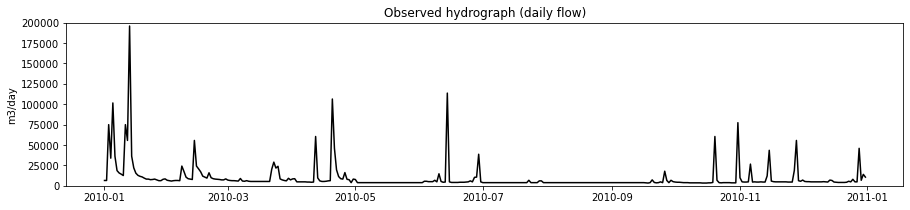

In [4]:
plt.figure(figsize=(15,3)) # to define the plot size
plt.plot(obs_data_year.index, obs_data_year['outflow'], color = 'black', label = 'observed')
plt.ylabel('m3/day')
plt.ylim([0,200000])
plt.title('Observed hydrograph (daily flow)')

### Model inputs

In [5]:
T = len(obs_data_year)
# Inputs
dates = obs_data_year.index
prec  = obs_data_year['rain']
etp   = obs_data_year['etp']
A = 500 * 10000 # ha to m2

### Define the hydrological model with 5 parameters

In [6]:
def hydro_model_5p(dates, prec, etp, soil_capacity, evap_ratio, perc_ratio, travel_time_surf, travel_time_sub):
    """
    Hydrological model adapted from the HyMOD model with 5 parameters.

    Parameters:
    soil_capacity (float): Maximum soil retention capacity (mm).
    evap_ratio (float): Evapotranspiration ratio (dimensionless).
    perc_ratio (float): Percolation ratio (dimensionless).
    travel_time_surf (float): Concentration time of surface flow.
    travel_time_sub (float): Concentration time of subsurface flow.

    Returns:
    tuple: (dates, Q_sim, Q_sub) - Simulated time series data.
    """
    # Initialization of variables
    T = len(prec)  # Total number of time steps, based on the length of the precipitation data
    effec_rain = np.zeros((T, 1))  # Effective rainfall (rainfall not infiltrated into the soil) [mm/time step]
    et = np.zeros((T, 1))          # Evapotranspiration rate (water loss due to evaporation and plant uptake) [mm/time step]
    sm = np.zeros((T + 1, 1))      # Soil moisture content at each time step [mm]
    sL = np.zeros((T + 1, 1))      # Moisture content in the slow (subsurface) reservoir [mm]
    sF = np.zeros((T + 1, 1))      # Moisture content in the fast (surface) reservoir [mm]
    q_sub = np.zeros((T, 1))       # Subsurface flow (baseflow) [mm/time step]
    q_sur = np.zeros((T, 1))       # Surface flow (runoff) [mm/time step]

    # Simulation over all time steps
    for t in range(1, T):  # Start from time step 1 (time 0 is the initial condition)
        # Calculate effective rainfall as the excess of precipitation over soil capacity
        effec_rain[t] = max(sm[t-1] + prec[t] - soil_capacity, 0)

        # Temporary soil moisture after adding precipitation but before evapotranspiration or runoff
        sm_temp = min(max(sm[t-1] + prec[t], 0), soil_capacity)

        # Calculate actual evapotranspiration (et) using a correction factor (W) based on soil moisture
        W = min(np.abs(sm_temp / soil_capacity) * evap_ratio, 1) # Correction factor is proportional to soil saturation
        et[t] = W * etp[t]  # Convert potential evapotranspiration (etp) to actual evapotranspiration (et)

        # Update the slow reservoir (subsurface flow)
        sL[t] = sL[t-1] + perc_ratio * effec_rain[t] - q_sub[t-1] # Inflow from percolation minus previous outflow
        q_sub[t] = 1 / travel_time_sub * sL[t]  # Subsurface flow out of the reservoir

        # Update the fast reservoir (surface flow)
        sF[t] = sF[t-1] + (1 - perc_ratio) * effec_rain[t] - q_sur[t-1] # Inflow from non-percolated rain minus previous outflow
        q_sur[t] = 1 / travel_time_surf * sF[t]  # Surface flow out of the reservoir

        # Update soil moisture for the current time step
        sm[t] = min(max(sm[t-1] + prec[t] - et[t] - q_sub[t] - q_sur[t], 0), soil_capacity)

    # Convert results to volumetric flow (m³/day) for comparison with observations
    Q_sub = q_sub * 0.001 * A  # Convert subsurface flow from mm/time step to m³/day
    Q_sur = q_sur * 0.001 * A  # Convert surface flow from mm/time step to m³/day
    Q_sim = Q_sur + Q_sub      # Total simulated flow (surface + subsurface)

    return dates, Q_sim, Q_sub  # Return time series of dates, total flow and subsurface flow

### Exercise - Guess-the-parameter challenge
In order to understand the influence of the model parameters on the result we are going to make our model more interactive using widgets, and more specifically sliders. Now you will be able to **play with the values of the parameters**, however the name of each parameter is not specified. After running the code below, try to answer the questions that you will find at the end.

In [7]:
interact(interactive_plot_1, p1 = (0.01, 0.99, 0.05), p2 = (0.01, 0.99, 0.05), p3 = (0.01, 0.99, 0.05), 
          p4 = (0.01, 0.99, 0.05), p5 = (0.01, 0.99, 0.05))

interactive(children=(FloatSlider(value=0.5, description='p1', max=0.99, min=0.01, step=0.05), FloatSlider(val…

<function util.interactive_plots.interactive_plot_1(p1=0.5, p2=0.5, p3=0.5, p4=0.5, p5=0.5)>

**Questions**: Which parameter (p1,p2,p3, p4, p5) corresponds to:
- **Soil storage capacity**
- **Evaporation ratio**
- **Percolation ratio**
- **Travel time - surface flow**
- **Travel time - underground flow**

**IMPORTANT**: Explain your answers